# DLAI Project

First of all we will import all libraries necessary to develop the project

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)

from math import ceil
print("Libraries imported successfully!")

Libraries imported successfully!


In the following piece of code the MNIST dataset is downloded to be able to work with it along all the project.

In [0]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
print("MNIST train set has %d samples" % len(mnist_trainset))
print("MNIST test set has %d samples" % len(mnist_testset))

0it [00:00, ?it/s]

9920512it [00:05, 1852809.32it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 443022.77it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 6839436.65it/s]                           
8192it [00:00, 171576.50it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
MNIST train set has 60000 samples
MNIST test set has 10000 samples


Now we will create the validation set with 5% of the training data and so the 95% of the original training set will be used to train the networks

In [0]:
validation_split = 0.05
random_seed= 30 #random_seed canviar
dataset_size = len(mnist_trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

# Shuffle dataset
torch.manual_seed(random_seed)
np.random.seed(random_seed)
np.random.shuffle(indices)

# Get samples indices
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Exercise 1

In this exercise it is required to implement a convolutional autoencoder with separated Encoder and Decoder. To do so will create the Encoder and the Decoder class.

First of all we fill create the list of parameters for the encoder and decoder classes.

In [0]:
hparams = {
    'batch_size':128,
    'num_epochs':20,
    'test_batch_size':64,
    'num_classes':10,
    'learning_rate':1e-2,
    'pretrained_learning_rate': 1e-5,
    'log_interval':50,
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

With the parameters initialized we now create bothe the Encoder and the Decoder and then the full Convolutional Autoencoder. The design of this autoencoder is based on the Convolutional AutoEncoder for MNIST which can be found in this [link](researchgate.net/publication/320658590_Deep_Clustering_with_Convolutional_Autoencoders)

The size of the filters for each convolution layer have been computed as following F = I - S * (Out - 1)

Encoder:

conv2: F = 28 - 2 * (14 - 1) = 2

conv3: F = 14 - 2 * (7 - 1) = 2

conv4: F = 7 - 2 * (3 - 1) = 3

In [0]:
class ConvEncoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.conv1 = nn.Conv2d(1,16,3, padding=1)
    self.conv2 = nn.Conv2d(16,32,3, stride=2)
    self.conv3 = nn.Conv2d(32,64,2,stride=2)
    self.conv4 = nn.Conv2d(64,128,2,stride=2)
    self.relu = nn.ReLU()
    self.mlp = nn.Sequential(
        nn.Linear(3*3*128,bottleneck),
        nn.ReLU()
    )

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))
    x= x.view(x.shape[0], -1)
    x = self.mlp(x)
    return x

In [0]:
class ConvDecoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(bottleneck,3*3*128),
        nn.ReLU()
    )
    self.relu = nn.ReLU()
    self.deconv4 = nn.ConvTranspose2d(128,64,3, stride=2)
    self.deconv3 = nn.ConvTranspose2d(64,32,2, stride=2)
    self.deconv2 = nn.ConvTranspose2d(32,16,2, stride=2)
    self.deconv1 = nn.ConvTranspose2d(16,1,3, padding = 1)
    self.sigmoid = nn.Sigmoid()
    #sigmoid function because it is naturally scaled between 0 and 1


  def forward(self, x):
    x = self.relu(self.mlp(x))
    x = x.view(x.shape[0], 128, 3, 3)
    x = self.relu(self.deconv4(x))
    x = self.relu(self.deconv3(x))
    x = self.relu(self.deconv2(x))
    x = self.sigmoid(self.deconv1(x))
    return x

In [0]:
class ConvAutoencoder(nn.Module):
  def __init__(self, bottleneck):
    super().__init__()
    self.encoder = ConvEncoder(bottleneck)
    self.decoder = ConvDecoder(bottleneck)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

With the convolutional autoencoder defined, we will now define the train function.

In [0]:
def train(train_loader, validation_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  train_losses = []
  val_losses = []
  network.train()
  device = hparams['device']
  for epoch in range(hparams['num_epochs']):
    val_loss=0.0
    num=0
    for data in train_loader: #lo de enumerate fa que peti
      img, idx = data
      img= img.to(device)
      idx=idx.to(device)
      output = network(img)
      loss = criterion(output, img)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      num+=1
      if num % hparams['log_interval'] == 0:
        print('epoch [{}/{}], [{}/{} ({:.0f}%)]\tloss:{:.4f}'.format(epoch+1, hparams['num_epochs'], num * len(img), len(train_loader.sampler),
              100. * num / len(train_loader), loss.item()))

    # Validation
    network.eval()
    with torch.no_grad():
        for data in validation_loader:
            img, _ = data
            img= img.to(device)
            output = network(img)
            val_loss += criterion(output, img).item() # sum up batch loss
        val_loss /= len(validation_loader)
    val_losses.append(val_loss)
    print('\nValidation set: Loss: {:.4f} \n'.format(val_loss))

  return train_losses, val_losses


Now we create the three data loaders using the parameters defined above

In [0]:
train_loader = torch.utils.data.DataLoader(mnist_trainset,
                                           batch_size=hparams['batch_size'], 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(mnist_trainset,
                                                batch_size=hparams['test_batch_size'],
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=hparams['test_batch_size'],
                                          shuffle=False)

We are now ready to train our convolutional autoencoder with different bottleneck sizes.

In [0]:
#TODO: Train autoencoder with different sizes
# set model, loss function and optimizer
# Init lists to save the evolution of the training & test losses/accuracy.
bottlenecks=[5, 10, 15, 20, 50]
criterion = nn.MSELoss()
networks = [None] * len(bottlenecks)
train_size = (1-validation_split)*dataset_size
n_steps = ceil(train_size/hparams['batch_size'])*hparams['num_epochs']
train_losses = np.empty((len(bottlenecks),n_steps))
val_losses = np.empty((len(bottlenecks), hparams['num_epochs']))

for i in range(len(bottlenecks)): # va de 0 a 4
  network = ConvAutoencoder(bottlenecks[i])
  network.to(hparams['device'])
  optimizer = optim.Adam(network.parameters(),
                        lr=hparams['learning_rate'])

  train_losses_b,val_losses_b = train(train_loader, validation_loader, network, optimizer, criterion, hparams)
  #el següent no es pot fer pq train_losses_b es una list
  #print("train_losses_b.shape= {}, val_losses_b.shape= {}".format(train_losses_b.shape,val_losses_b.shape)) 
  print("len(train_losses_b)= {}, len(val_losses_b)= {}".format(len(train_losses_b),len(val_losses_b))) 
  networks[i]=network
  #print("\n Abans del append: train_losses.shape= {}, val_losses.shape= {}".format(train_losses.shape,val_losses.shape)), aquí encara és una llista
  train_losses[i,:] = train_losses_b #això hauria de ser una llista de llistes, però continua sent una llista
  val_losses[i,:]= val_losses_b

  #test_loss=test_epoch(validation_loader, network, criterion, hparams)
  #test_losses.append(test_loss)

epoch [1/20], [100/60000 (11%)]	loss:0.7246
epoch [1/20], [200/60000 (22%)]	loss:0.6460
epoch [1/20], [300/60000 (34%)]	loss:0.6153
epoch [1/20], [400/60000 (45%)]	loss:0.6101
epoch [1/20], [500/60000 (56%)]	loss:0.5938
epoch [1/20], [600/60000 (67%)]	loss:0.6122
epoch [1/20], [700/60000 (78%)]	loss:0.5754
epoch [1/20], [800/60000 (90%)]	loss:0.5770

Validation set: Average loss: 0.5760 

epoch [2/20], [100/60000 (11%)]	loss:0.5444
epoch [2/20], [200/60000 (22%)]	loss:0.5521
epoch [2/20], [300/60000 (34%)]	loss:0.5855
epoch [2/20], [400/60000 (45%)]	loss:0.5461
epoch [2/20], [500/60000 (56%)]	loss:0.5164
epoch [2/20], [600/60000 (67%)]	loss:0.5241
epoch [2/20], [700/60000 (78%)]	loss:0.5123
epoch [2/20], [800/60000 (90%)]	loss:0.4949

Validation set: Average loss: 0.5062 

epoch [3/20], [100/60000 (11%)]	loss:0.5029
epoch [3/20], [200/60000 (22%)]	loss:0.4975
epoch [3/20], [300/60000 (34%)]	loss:0.4872
epoch [3/20], [400/60000 (45%)]	loss:0.4838
epoch [3/20], [500/60000 (56%)]	loss:0.4

Let's see how the training and validation loss evolution looks like

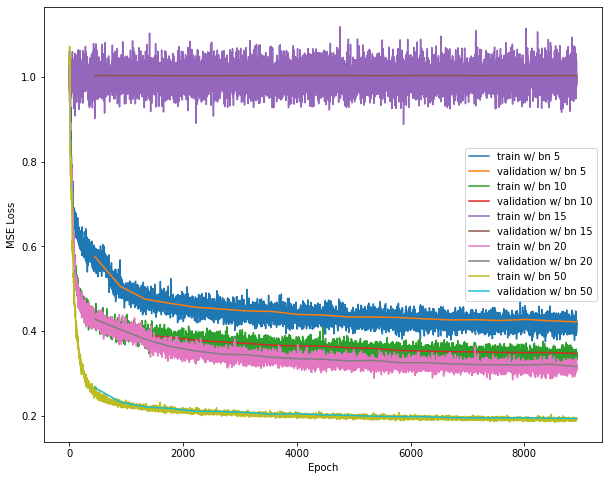

In [0]:
interval = ceil(train_size/hparams['batch_size'])
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
for i in range(len(bottlenecks)):
  plt.plot(range(1,len(train_losses[i,:])+1),train_losses[i,:], label='train w/ bn '+str(bottlenecks[i]))
  plt.plot(range(1+interval,len(train_losses[i,:])+interval+1,interval),val_losses[i,:], label='validation w/ bn '+str(bottlenecks[i]))

plt.legend()

Let's see now how the reconstructed images look like.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#potser s'ha de canviar a la carpeta on estan totes les coses

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/gdrive/My Drive"
#!ls "/content/gdrive/My Drive/MATT/DLAI/Projecte_DLAI"

'AutoSearchParkingSystem(ASPS).pptx'   networks_1.pt
'Colab Notebooks'		       networks_2.pt
 Degree_academic_record.pdf	       networks_3.pt
 ex1.m				       networks_4.pt
 FormulaStudent2019		       TELECOS
 Master_academic_record.pdf	      'Telecos 1A - FDF.zip'
 MATT				      'WHERE?.gmap'
 networks_0.pt


In [0]:
for i in range(len(bottlenecks)):
  model_save_name = 'networks_'+str(i)+'.pt'
  path = F"/content/gdrive/My Drive/{model_save_name}"
  torch.save({
      'model_state_dict': networks[i].state_dict(), 
      'train_losses':train_losses[i,:],
      'val_losses':val_losses[i,:]},
      path)

In [0]:
bottlenecks=[5, 10, 15, 20, 50]
networks = [None] * len(bottlenecks)
train_size = (1-validation_split)*dataset_size
n_steps = ceil(train_size/hparams['batch_size'])*hparams['num_epochs']
train_losses = np.empty((len(bottlenecks),n_steps))
val_losses = np.empty((len(bottlenecks), hparams['num_epochs']))

for i in range(len(bottlenecks)):
  networks[i]= ConvAutoencoder(bottlenecks[i])
  model_save_name = 'networks_'+str(i)+'.pt'
  path = F"/content/gdrive/My Drive/{model_save_name}"
  checkpoint = torch.load(path)
  networks[i].load_state_dict(checkpoint['model_state_dict'])
  train_losses[i,:]=checkpoint['train_losses']
  val_losses[i,:]=checkpoint['val_losses']

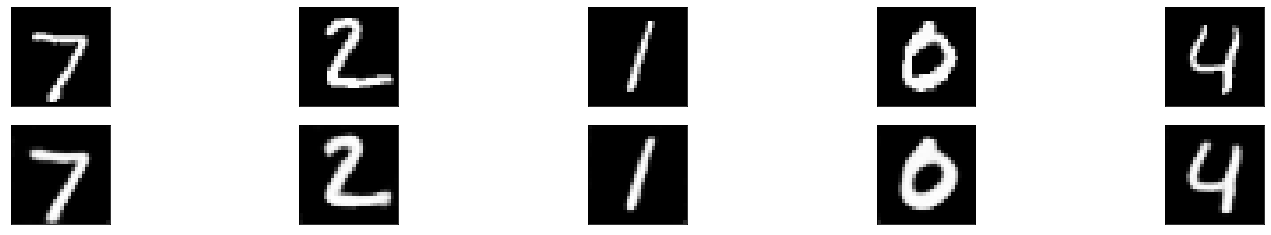

In [0]:
#Plot the reconstructed images
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs (from the best model from the previous:network_x)
best_net=networks[4]
best_net.eval() 
best_net.to('cpu')
output = best_net(images)
# prep images for display
images = images.numpy()

# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first five input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Now we will use the Decoder as an image generator. We inject random values to the decoder and create 5 new images.

torch.Size([5, 5])


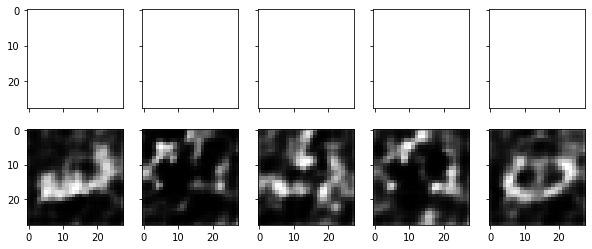

In [0]:
# Generate 5 random vectors (of bottleneck size) to generate images #review
bottleneck=5 #de best neck
inputs_bottleneck = torch.randn(5,bottleneck).to(hparams['device'])
print(inputs_bottleneck.shape)
#només hem de fer input al decoder... o sigui hem de "truncar" i passar-li només al decoder les dades (entenc que agafant els weights del decoder ja entrenat)

#networks[4].eval() #no sé si això cal tornar-ho a posar
networks[0].to('cpu')
outputs= networks[0].decoder(inputs_bottleneck).detach().cpu().numpy()
#outputs = best_net(inputs).detach().cpu().numpy() #d'un dels models, però només la part de decoder...
#print(outputs[1])

num_inputs = inputs_bottleneck.shape[0]
fig, axes = plt.subplots(nrows=2, ncols=num_inputs, sharex=True, sharey=True, figsize=(10,4))
for i in range(num_inputs):
  #axes[0][i].imshow(np.squeeze(inputs_bottleneck[i]), cmap='gray')
  axes[1][i].imshow(np.squeeze(outputs[i]), cmap='gray')
fig.show() #això els del t3 han fet algo però no és el que demanava exactament...

## Exercise 2

First we will select a subset of 100 images and its associated labels

In [0]:
#100 de train_indices
#5 de val_indices
subset_train_indices = np.random.choice(train_indices,100)
subset_val_indices = np.random.choice(val_indices,50)

subset_train_sampler = SubsetRandomSampler(subset_train_indices)
subset_valid_sampler = SubsetRandomSampler(subset_val_indices)

subset_train_loader = torch.utils.data.DataLoader(mnist_trainset,
                                           batch_size=hparams['batch_size'], 
                                           sampler=subset_train_sampler)
subset_validation_loader = torch.utils.data.DataLoader(mnist_trainset,
                                                batch_size=hparams['test_batch_size'],
                                                sampler=subset_valid_sampler)

Then we select one of the previous trained autoencoders and from its encoder we will buid a new model for classification task.

In [0]:
class EncoderClassifier(nn.Module):
  def __init__(self, bottleneck):
    super().__init__()
    self.encoder = ConvEncoder(bottleneck)
    self.lin_proj = nn.Sequential(
      nn.Linear(bottleneck,10), #bottlenecks[min_valError_idx]
      nn.ReLU(),
      nn.LogSoftmax(),
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.lin_proj(x)
    return x

We generate the new train function for the classifier

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train(train_loader, validation_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  train_losses = []
  val_losses = []
  test_acc = []
  network.train()
  device = hparams['device']
  for epoch in range(hparams['num_epochs']):
    val_loss=0.0
    num=0
    for data in train_loader: #lo de enumerate fa que peti
      img, labels = data
      img = img.to(device)
      labels = labels.to(device)
      output = network(img)
      loss = criterion(output, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      num+=1
      if num % hparams['log_interval'] == 0:
        print('epoch [{}/{}], [{}/{} ({:.0f}%)]\tloss:{:.4f}'.format(epoch+1, hparams['num_epochs'], num * len(data), len(train_loader.dataset),
              100. * num / len(train_loader), loss.item()))

    # Validation
    network.eval()
    acc = 0
    with torch.no_grad():
        for data in validation_loader:
            img, labels = data
            img = img.to(device)
            labels = labels.to(device)
            output = network(img)
            acc += correct_predictions(output, labels)
            val_loss += criterion(output, labels).item() # sum up batch loss
        val_loss /= len(validation_loader)
    val_losses.append(val_loss)
    test_acc.append(acc / len(validation_loader.sampler))
    print('\nValidation set: Loss: {:.4f} \n'.format(val_loss))
    print('\nValidation set: Accuracy: {:.4f} \n'.format(acc / len(validation_loader.sampler)))
  return train_losses, val_losses, test_acc


Using the pretrained weights we will now train the new model for classification.

In [0]:
min_valError_idx = np.argmin(val_losses[:,-1])
enc = networks[min_valError_idx].encoder

pretrained_classifier = EncoderClassifier(bottlenecks[min_valError_idx])
pretrained_classifier.encoder = enc
pretrained_classifier.to(hparams['device'])

optimizer = optim.Adam(pretrained_classifier.parameters(),
                        lr=hparams['learning_rate'])
criterion = nn.NLLLoss()

train_losses_pt,val_losses_pt, acc_pt= train(subset_train_loader, subset_validation_loader, pretrained_classifier, optimizer, criterion, hparams)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Validation set: Loss: 2.1752 


Validation set: Accuracy: 0.2400 


Validation set: Loss: 1.8046 


Validation set: Accuracy: 0.4400 


Validation set: Loss: 1.6340 


Validation set: Accuracy: 0.4600 


Validation set: Loss: 1.5360 


Validation set: Accuracy: 0.4400 


Validation set: Loss: 1.4586 


Validation set: Accuracy: 0.5000 


Validation set: Loss: 1.3993 


Validation set: Accuracy: 0.5000 


Validation set: Loss: 1.3591 


Validation set: Accuracy: 0.5200 


Validation set: Loss: 1.3274 


Validation set: Accuracy: 0.5200 


Validation set: Loss: 1.2977 


Validation set: Accuracy: 0.5200 


Validation set: Loss: 1.2749 


Validation set: Accuracy: 0.5400 


Validation set: Loss: 1.2580 


Validation set: Accuracy: 0.5600 


Validation set: Loss: 1.2468 


Validation set: Accuracy: 0.5800 


Validation set: Loss: 1.2411 


Validation set: Accuracy: 0.5600 


Validation set: Loss: 1.2447 


Validation set: Accuracy: 0.5600 


Validation set: Loss: 1.2578 


Validation set:

Now we will fine-tune the classification layer training each part of the model with different learning rates. The pre-trained part will be trained with a very low learning rate whereas the new classification layer will be trained with a normal learning rate.

In [0]:
finetuned_classifier = EncoderClassifier(bottlenecks[min_valError_idx])
finetuned_classifier.encoder = enc

finetuned_classifier.to(hparams['device'])
optimizer = optim.Adam([{'params': finetuned_classifier.encoder.parameters(),
                         'lr': hparams['pretrained_learning_rate']},
                        {'params': finetuned_classifier.lin_proj.parameters()}],
                        lr = hparams['learning_rate'])
criterion = nn.NLLLoss()
train_losses_ft,val_losses_ft, acc_ft = train(subset_train_loader, subset_validation_loader, finetuned_classifier, optimizer, criterion, hparams)


Validation set: Loss: 3.0604 


Validation set: Accuracy: 0.0400 



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Validation set: Loss: 2.5301 


Validation set: Accuracy: 0.0800 


Validation set: Loss: 2.1348 


Validation set: Accuracy: 0.2400 


Validation set: Loss: 1.9071 


Validation set: Accuracy: 0.4000 


Validation set: Loss: 1.7808 


Validation set: Accuracy: 0.4600 


Validation set: Loss: 1.7070 


Validation set: Accuracy: 0.4800 


Validation set: Loss: 1.6509 


Validation set: Accuracy: 0.4800 


Validation set: Loss: 1.6019 


Validation set: Accuracy: 0.4800 


Validation set: Loss: 1.5532 


Validation set: Accuracy: 0.5000 


Validation set: Loss: 1.5004 


Validation set: Accuracy: 0.5000 


Validation set: Loss: 1.4415 


Validation set: Accuracy: 0.5800 


Validation set: Loss: 1.3683 


Validation set: Accuracy: 0.6000 


Validation set: Loss: 1.2870 


Validation set: Accuracy: 0.6200 


Validation set: Loss: 1.2131 


Validation set: Accuracy: 0.6200 


Validation set: Loss: 1.1499 


Validation set: Accuracy: 0.6200 


Validation set: Loss: 1.0969 


Validation set:

Here we will train all the model from scratch using the 100 samples 

In [0]:
scratch_classifier = EncoderClassifier(bottlenecks[min_valError_idx])
scratch_classifier.to(hparams['device'])

optimizer = optim.Adam(scratch_classifier.parameters(),
                        lr=hparams['learning_rate'])
criterion = nn.NLLLoss()

train_losses_sc,val_losses_sc, acc_sc = train(subset_train_loader, subset_validation_loader, scratch_classifier, optimizer, criterion, hparams)


Validation set: Loss: 2.3199 


Validation set: Accuracy: 0.0200 


Validation set: Loss: 2.3020 


Validation set: Accuracy: 0.1200 



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Validation set: Loss: 2.3309 


Validation set: Accuracy: 0.0200 


Validation set: Loss: 2.4278 


Validation set: Accuracy: 0.0400 


Validation set: Loss: 2.2842 


Validation set: Accuracy: 0.1400 


Validation set: Loss: 2.2612 


Validation set: Accuracy: 0.1600 


Validation set: Loss: 2.2793 


Validation set: Accuracy: 0.2000 


Validation set: Loss: 2.3843 


Validation set: Accuracy: 0.2400 


Validation set: Loss: 2.1554 


Validation set: Accuracy: 0.2800 


Validation set: Loss: 2.0893 


Validation set: Accuracy: 0.2400 


Validation set: Loss: 2.3349 


Validation set: Accuracy: 0.2400 


Validation set: Loss: 2.0562 


Validation set: Accuracy: 0.3000 


Validation set: Loss: 2.0126 


Validation set: Accuracy: 0.3000 


Validation set: Loss: 2.1540 


Validation set: Accuracy: 0.2400 


Validation set: Loss: 2.1666 


Validation set: Accuracy: 0.2800 


Validation set: Loss: 2.0740 


Validation set: Accuracy: 0.3200 


Validation set: Loss: 2.0815 


Validation set:

Let's compare now the accuracy results of all the previous models

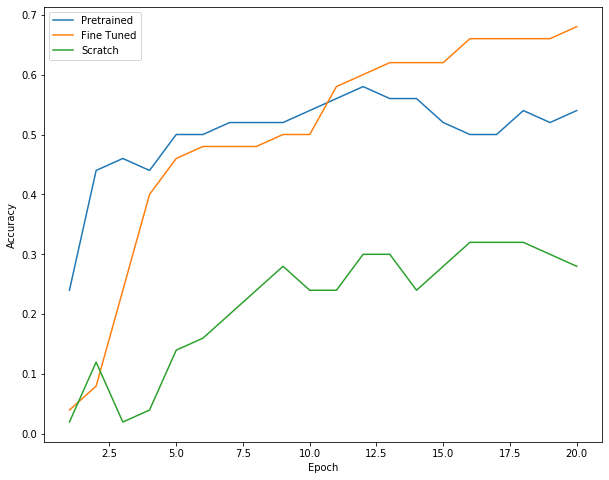

In [0]:
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1,len(acc_pt)+1),acc_pt, label='Pretrained')
plt.plot(range(1,len(acc_pt)+1),acc_ft, label='Fine Tuned')
plt.plot(range(1,len(acc_pt)+1),acc_sc, label='Scratch')
plt.legend()

In [0]:
When transfer learning. the convergence is much faster
Training from scratch, the conv is much slower, a very high overfitting effect
Però tots s'han d'entrenar més o menys bé

SyntaxError: ignored

## Exercise 3

## Exersice 4